<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.3
IPython 6.1.0

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
matplotlib 2.1.0
sklearn 0.19.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.0.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [3]:
!vw --version

8.5.0


##  1.1. Линейная регрессия и SGD

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [55]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=0.001, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []         

    def fit(self, X , y):
        X = np.hstack([np.ones((len(X), 1)), X])
        w = np.zeros(X.shape[1])
        
        for i in range(self.n_iter):
            w = w + self.eta * (y[i] - np.dot (X[i], w)) * X[i]
            
            self.mse_.append(mean_squared_error(y, np.dot (X, w) ))
            self.weights_.append(w)
            
        min_mse, best_iter = min((self.mse_[i], i )for i in range(len(self.mse_)))
        self.w_ = self.weights_[best_iter] 
        return self 
    
    
    def predict(self, X):
        X = np.hstack([np.ones((len(X), 1)), X])
        return np.dot(X, self.w_)    
        

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [56]:
data_demo = pd.read_csv('data/weights_heights.csv')

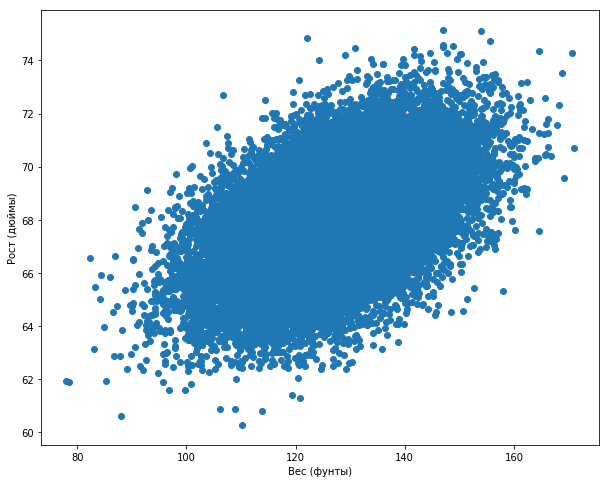

In [57]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [58]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [60]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [62]:
regressor = SGDRegressor(eta = 0.1, n_iter = 100).fit(X_train_scaled, y_train)


Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

Text(0,0.5,'MSE')

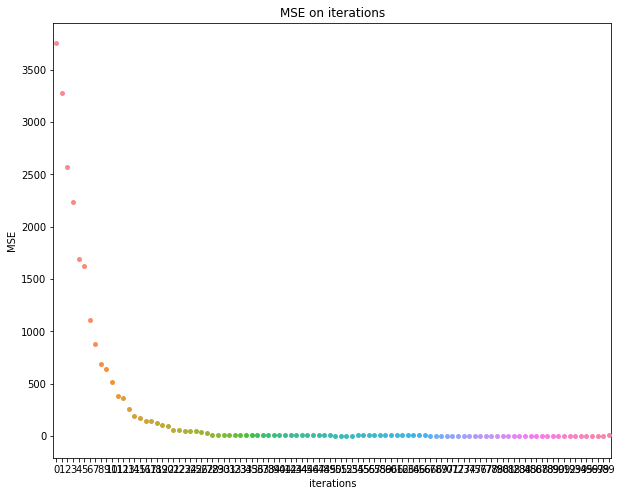

In [65]:
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 8
sns.swarmplot(x = np.arange(100)  , y = regressor.mse_)
plt.title('MSE on iterations')
plt.xlabel('iterations')
plt.ylabel('MSE')

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [53]:
regressor

SGDRegressor(eta=0.001, n_iter=10)

In [54]:
print(regressor.w_, ' gives ', np.min(regressor.mse_), ' error ')


[ 0.68280208 -0.2235846 ]  gives  4534.24738124  error 


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

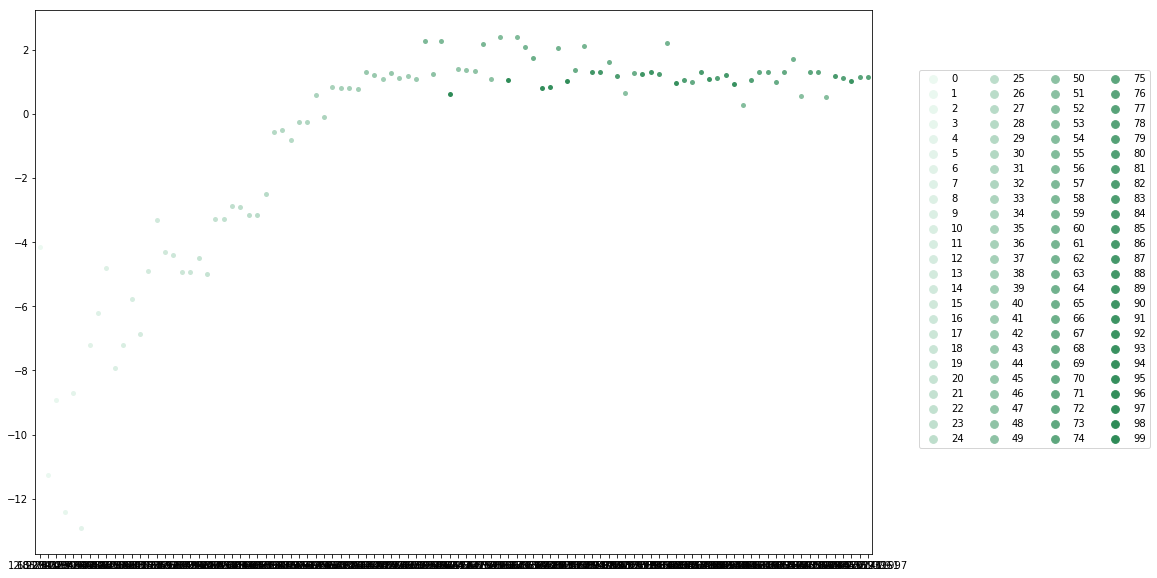

In [15]:
plt.rcParams['figure.figsize'] = (15, 10 )
w = np.asarray ( regressor.weights_ )
steps = np.arange(len(w))
palette = sns.light_palette("seagreen", reverse=False,  n_colors=len(steps) )
sns.swarmplot(w[:, 0] , w[: , 1 ], hue=steps, palette = palette)
plt.legend(bbox_to_anchor=(1.05, 0.9), ncol=4)



Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [16]:
predictions = regressor.predict(X_valid_scaled)
print('MSE is ' , mean_squared_error(predictions, y_valid))

MSE is  2.67083069029


Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [17]:
from sklearn import linear_model
skl_regressor = linear_model.LinearRegression( ).fit(X_train_scaled, y_train)
predictions = skl_regressor.predict(X_valid_scaled)
print('MSE is ', mean_squared_error(predictions, y_valid))


MSE is  2.67083076767


<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - **$w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$**
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [24]:
from sklearn.metrics import log_loss

In [25]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))
def kronecker(w):
    w = w
    w[0] = 0
    return w

In [26]:
def sign(a):
    if a < 0 : return -1
    if a >= 0 : return 1 

In [66]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C , eta=0.001, n_iter=10  ):
        self.C = C
        self.eta = eta
        self.n_iter = n_iter 
        self.loss_ = []
        self.weights_ = []
    
    def fit ( self, X , y ) :
        X = np.hstack([np.ones((len(X), 1)), X])
        w = np.zeros(X.shape[1])
        for i in range(self.n_iter) : 
            w = w + self.eta  * (self.C* y[i] * sigma( - y[i] * np.dot(w, X[i])) * X[i] - kronecker(w) ) 
            self.weights_.append(w)
            self.loss_.append (log_loss( y , [sign(a) for a in np.dot(X , w)]) )
               
        min_loss , best_iter = min((self.loss_[i], i) for i in range(len(self.loss_)))    
        self.w_ = self.weights_[best_iter]
        return self 
    
    
    def predict(self,  X ):
        X = np.hstack([np.ones((len(X), 1)), X])
        predictions = [sign(a) for a in np.dot(X , self.w_)]
        return predictions 
    
    def predict_proba ( self, X ):
        X = np.hstack([np.ones((len(X), 1)), X])
        predictions = np.dot (X , self.w_)
        probabilities = [sigma(p_i) for p_i in predictions]
        
        return probabilities

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [67]:
from sklearn.datasets import load_breast_cancer

In [68]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [71]:
classifier = SGDClassifier(C=1, eta=0.001, n_iter=3).fit(X_train_scaled, y_train)
predictions = classifier.predict(X_valid_scaled)

Постройте график изменения log_loss.

Text(0,0.5,'log_loss')

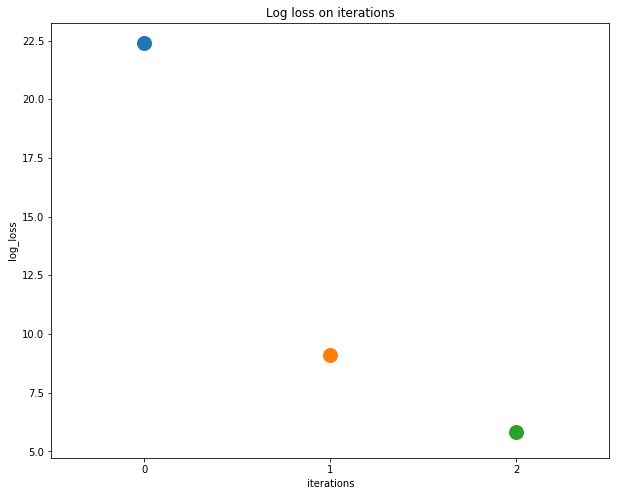

In [72]:
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 8
sns.swarmplot(x = np.arange(3)  , y = classifier.loss_, size=15)
plt.title('Log loss on iterations')
plt.xlabel('iterations')
plt.ylabel('log_loss')

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [73]:
classifier = SGDClassifier(C=1000, eta=0.001, n_iter=10).fit(X_train_scaled, y_train)

Text(0,0.5,'log_loss')

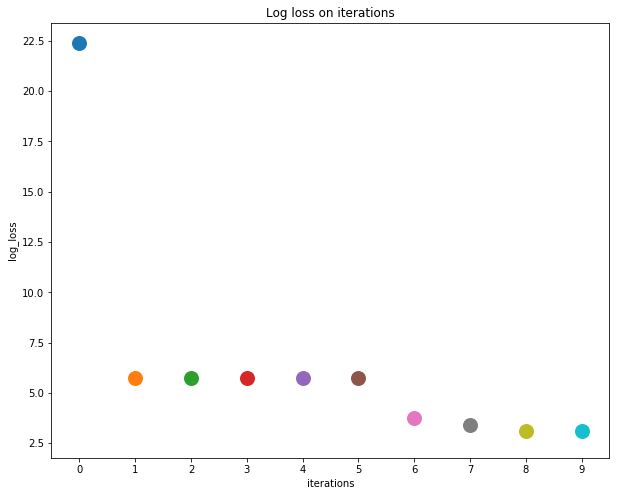

In [74]:
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 8
sns.swarmplot(x = np.arange(10)  , y = classifier.loss_, size=15)
plt.title('Log loss on iterations')
plt.xlabel('iterations')
plt.ylabel('log_loss')

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - **worst concavity**
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [75]:
max_weight = max(classifier.w_, key = lambda x: abs(x))
i = list(classifier.w_).index(max_weight)
print('the most important feature is    ', cancer.feature_names[i-1])#because there's feature==1

the most important feature is     worst compactness


Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [76]:
from sklearn.metrics import roc_auc_score

In [77]:
predictions = classifier.predict(X_valid_scaled)
print('log_loss is ', log_loss(predictions, y_valid))
print('ROC_AUC is ', roc_auc_score(predictions, y_valid))

log_loss is  4.03969311029
ROC_AUC is  0.869366197183


In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
skl_classifier = LogisticRegression( random_state = 17 ).fit(X_train_scaled, y_train)
predictions = skl_classifier.predict(X_valid_scaled)
print('log_loss is ', log_loss(predictions, y_valid))
print('ROC_AUC is ', roc_auc_score(predictions, y_valid))

log_loss is  0.807924594033
ROC_AUC is  0.982456140351


## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [41]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [42]:
# поменяйте путь к файлу
reviews_train = load_files("/Users/lena/Documents/ML/ODS/data/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [43]:
reviews_test = load_files("/Users/lena/Documents/ML/ODS/data/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [157]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 27 s, sys: 671 ms, total: 27.6 s
Wall time: 28 s


In [23]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [160]:
logit = LogisticRegression(random_state = 17).fit ( X_train , y_train)
predictions = logit.predict( X_test)
print ( 'ROC_AUC is ', roc_auc_score(predictions , y_test) ) 

ROC_AUC is  0.896291385293


Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - **Реализована ранняя остановка во избежание переобучения**
 - Есть распараллеливание по процессорам
 - **Можно обучать LASSO**
 - Поддерживается онлайн-обучение деревьев решений
 - **Поддерживается mini-batch подход (обновление весов по нескольким объектам сразу, а не по одному)**


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [165]:
%%time
logit = SGDClassifier(random_state = 17 , max_iter=100).fit ( X_train , y_train)
predictions = logit.predict( X_test)
print ( 'ROC_AUC is ', roc_auc_score(predictions , y_test) ) 

ROC_AUC is  0.886331208854
CPU times: user 4.61 s, sys: 54.9 ms, total: 4.66 s
Wall time: 4.74 s


<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - **2**
 - 3
 - 4
 - 5